In [322]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import logging

from sklearn.preprocessing import StandardScaler

from scipy.stats import skew, kurtosis

from utils.general import *

import json

import warnings

In [323]:
warnings.filterwarnings('ignore')

In [324]:
random_state = 42
rng = np.random.default_rng(random_state)

# Data Loading And Preprocessing

In [325]:
billboard_df = pd.read_csv("../data/billboard/hot-100_all.csv")
spotify_df = pd.read_csv("../data/spofity/songs.csv")
audio_analysis_df = pd.read_csv("../data/audio/audio_features_full.csv")

In [326]:
billboard_df.drop(axis=1, inplace=True, labels=['image', 'artist'])
billboard_df['date'] = pd.to_datetime(billboard_df['date'])
spotify_df.drop(axis=1, inplace=True, labels=['spotify_name',
                                              'artist',
                                              'artist_genres',
                                              'spotify_id',
                                              'spotify_id',
                                              'spotify_uri',
                                              'spotify_external_url',
                                              'spotify_artist_popularity',
                                              'preview_url',
                                              'preview_url_audio',
                                              'full_audio',
                                              'full_audio_duration_s'
                                              ])
audio_analysis_df.drop(axis=1, inplace=True, labels=['name', 'tempo'])

In [327]:
songs_df = spotify_df.merge(audio_analysis_df, how='inner', on='billboard_name')
songs_df

,billboard_name,duration_ms,spotify_popularity,spotify_artist_popularity_mean,explicit,danceability,energy,key,loudness,mode,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,All I Want For Christmas Is You,241106.0,69.0,81.000000,False,0.336,0.627,7.0,-7.463,1.0,...,1.619618,99.735660,-3.865835,99.024666,2.729783,112.219580,-7.488522,122.569650,2.323859,141.572560
1,Rockin' Around The Christmas Tree,126266.0,62.0,59.000000,False,0.589,0.472,8.0,-8.749,1.0,...,-1.039626,78.420586,-4.437555,55.536427,3.890496,70.359543,0.014326,77.899239,6.889563,93.610161
2,Jingle Bell Rock,130973.0,62.0,50.000000,False,0.754,0.424,2.0,-8.463,1.0,...,1.430321,58.685158,-4.030815,67.332291,1.802275,58.469532,-5.335912,53.423290,0.133941,58.774597
3,A Holly Jolly Christmas,135533.0,54.0,48.000000,False,0.683,0.375,0.0,-13.056,1.0,...,-1.355817,60.197350,-6.695084,52.782772,-4.325858,66.221947,-3.533713,50.849602,-1.266797,90.991325
4,Circles,215280.0,86.0,91.000000,False,0.695,0.762,0.0,-3.497,1.0,...,2.563944,78.141319,-12.359889,83.661438,4.207565,65.643173,-5.280680,54.441185,-0.751733,59.799530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,Christmas Isn't Canceled (Just You),231549.0,41.0,77.000000,False,0.580,0.789,1.0,-4.918,0.0,...,5.321839,70.412506,1.213545,77.698616,4.693950,85.284431,-2.604682,76.687698,5.805956,77.433144
1419,Moved To Miami,222225.0,66.0,88.500000,True,0.717,0.444,1.0,-11.126,1.0,...,4.598643,180.801086,-4.373017,110.878738,4.545245,111.550697,4.918246,63.780304,8.114554,75.806396
1420,Hibachi,170413.0,69.0,86.333333,True,0.681,0.522,5.0,-8.740,0.0,...,8.091636,79.854568,-1.646704,123.382797,5.309008,98.507568,0.213412,80.767159,2.804790,73.490234
1421,Thailand,200958.0,70.0,84.000000,True,0.875,0.478,7.0,-10.562,1.0,...,10.420262,91.743813,-2.071233,75.112267,8.341298,97.730263,-0.260812,69.875168,1.959964,62.722679


In [328]:
# print(songs_df.apply(lambda x: x.nunique()))
songs_df.describe()

,duration_ms,spotify_popularity,spotify_artist_popularity_mean,danceability,energy,key,loudness,mode,speechiness,acousticness,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,...,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,200696.557976,67.404076,83.302977,0.666045,0.622016,5.153197,-6.747289,0.622628,0.139837,0.223816,...,2.398114,84.513799,-3.647905,82.115186,2.668189,80.818220,-2.539943,79.075432,1.677588,80.371770
std,50770.975125,17.661345,12.018877,0.151579,0.162841,3.600340,2.579960,0.484900,0.125819,0.253148,...,3.631675,24.471115,3.398574,24.637780,3.253561,24.665541,3.023733,24.767819,3.186344,26.740148
min,32000.000000,0.000000,0.000000,0.150000,0.007600,0.000000,-33.663000,0.000000,0.023200,0.000003,...,-13.240079,32.670311,-18.392536,31.161884,-10.105947,31.325922,-14.229393,28.560005,-13.992401,28.597084
25%,170322.000000,64.000000,78.000000,0.570000,0.525000,1.000000,-7.841500,0.000000,0.042800,0.031550,...,0.246056,68.009289,-5.805181,65.208897,0.716595,64.160015,-4.468847,62.009989,-0.239844,61.936447
50%,195428.000000,70.000000,86.000000,0.680000,0.633000,5.000000,-6.360000,1.000000,0.079800,0.121000,...,2.442511,81.295982,-3.595455,78.402687,2.753472,77.774918,-2.510375,75.437561,1.633557,75.101379
75%,223599.000000,77.000000,91.000000,0.776000,0.733500,8.000000,-5.077500,1.000000,0.218000,0.321500,...,4.722763,98.500587,-1.416037,94.838615,4.810408,93.118820,-0.625247,91.067223,3.652482,93.510078
max,613026.000000,95.000000,100.000000,0.965000,0.984000,11.000000,-1.321000,1.000000,0.699000,0.995000,...,13.629806,207.025589,6.795540,219.371109,12.521308,229.869766,7.686097,229.040588,14.772246,226.710175


In [329]:
songs_df.isna().sum()

billboard_name                    0
duration_ms                       0
spotify_popularity                0
spotify_artist_popularity_mean    0
explicit                          0
                                 ..
mfcc18_var                        0
mfcc19_mean                       0
mfcc19_var                        0
mfcc20_mean                       0
mfcc20_var                        0
Length: 75, dtype: int64

In [330]:
songs_df = pd.get_dummies(songs_df, prefix=['explicit'], columns=['explicit'])

# Feature Engineering

### I don't know what made me think we need *MORE* features, but here's more features...
Some extra feature engineering for spotify's audio analysis object that did't happen during dataset construction.

In [331]:
def spotify_audio_analysis(filename):
    file = open(filename)
    analysis_json = json.load(file)
    file.close()
    timbre_coefs = np.arange(1, 13)
    bars = analysis_json['bars']
    beats = analysis_json['beats']
    sections = analysis_json['sections']
    segments = analysis_json['segments']
    tatums = analysis_json['tatums']

    return pd.DataFrame(data={
        # "time_signature": [analysis_json['track']['time_signature']],
        # "mode": [analysis_json['track']['mode']],
        "num_bars": len(bars),
        "mean_bar_duration": np.mean([b['duration'] for b in bars]),
        "var_bar_duration": np.var([b['duration'] for b in bars]),
        "num_beats": len(beats),
        "mean_beat_duration": np.mean([b['duration'] for b in beats]),
        "var_beat_duration": np.var([b['duration'] for b in beats]),
        "num_sections": len(sections),
        "mean_section_duration": np.mean([s['duration'] for s in sections]),
        "var_section_duration": np.var([s['duration'] for s in sections]),
        "mean_section_tempo": np.mean([s['tempo'] for s in sections]),
        "var_section_tempo": np.var([s['tempo'] for s in sections]),
        "mean_section_loudness": np.mean([s['loudness'] for s in sections]),
        "var_section_loudness": np.var([s['loudness'] for s in sections]),
        # other section stuff
        "num_segments": len(segments),
        "mean_segment_duration": np.mean([s['duration'] for s in segments]),
        "var_segment_duration": np.var([s['duration'] for s in segments]),
        "mean_segment_loudness_start": np.mean([s['loudness_start'] for s in segments]),
        "var_segment_loudness_start": np.var([s['loudness_start'] for s in segments]),
        "mean_segment_loudness_max": np.mean([s['loudness_max'] for s in segments]),
        "var_segment_loudness_max": np.var([s['loudness_max'] for s in segments]),
        "mean_segment_loudness_max_time": np.mean([s['loudness_max_time'] for s in segments]),
        "var_segment_loudness_max_time": np.var([s['loudness_max_time'] for s in segments]),
        "mean_segment_loudness_end": np.mean([s['loudness_end'] for s in segments]),
        "var_segment_loudness_end": np.var([s['loudness_end'] for s in segments]),
        "mean_segment_loudness_start_max_diff": np.mean([abs(s['loudness_start'] - s['loudness_max']) for s in segments]),
        "var_segment_loudness_start_max_diff": np.var([abs(s['loudness_start'] - s['loudness_max']) for s in segments]),
        "mean_segment_loudness_start_end_diff": np.mean([abs(s['loudness_start'] - s['loudness_end']) for s in segments]),
        "var_segment_loudness_start_end_diff": np.var([abs(s['loudness_start'] - s['loudness_end']) for s in segments]),
        "mean_segment_loudness_max_end_diff": np.mean([abs(s['loudness_max'] - s['loudness_end']) for s in segments]),
        "var_segment_loudness_max_end_diff": np.var([abs(s['loudness_max'] - s['loudness_end']) for s in segments]),
        "mean_segment_num_pitches": np.mean([len(s['pitches']) for s in segments]),
        "var_segment_num_pitches": np.var([len(s['pitches']) for s in segments]),
        "mean_segment_num_pure_pitches": np.mean([len(np.array(s['pitches'])[np.array(s['pitches']) > 0.5]) for s in segments]),
        "var_segment_num_pure_pitches": np.var([len(np.array(s['pitches'])[np.array(s['pitches']) > 0.5]) for s in segments]),
        "mean_segment_timbre": np.mean([np.dot(s['timbre'], timbre_coefs) for s in segments]),
        "var_segment_timbre": np.var([np.dot(s['timbre'], timbre_coefs) for s in segments]),
        "num_tatums": len(tatums),
        "mean_tatum_duration": np.mean([t['duration'] for t in tatums]),
        "var_tatum_duration": np.var([t['duration'] for t in tatums]),
    }, index=[0])

##### This will take a little bit to run

In [332]:
aa = pd.DataFrame()
for i in range(len(songs_df)):
    aa = pd.concat([aa, spotify_audio_analysis("../data/spofity/audio_analysis/" + spotify_df['audio_analysis_file'].iloc[0])], axis=0)
aa.reset_index(inplace=True)
songs_df = pd.concat([songs_df, aa], axis=1)
songs_df.drop(labels='index', axis=1, inplace=True)

In [333]:
songs_df.describe()

,duration_ms,spotify_popularity,spotify_artist_popularity_mean,danceability,energy,key,loudness,mode,speechiness,acousticness,...,var_segment_loudness_max_end_diff,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,...,1.423000e+03,1423.0,1423.0,1.423000e+03,1.423000e+03,1.423000e+03,1.423000e+03,1423.0,1.423000e+03,1.423000e+03
mean,200696.557976,67.404076,83.302977,0.666045,0.622016,5.153197,-6.747289,0.622628,0.139837,0.223816,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
std,50770.975125,17.661345,12.018877,0.151579,0.162841,3.600340,2.579960,0.484900,0.125819,0.253148,...,8.316273e-13,0.0,0.0,3.331840e-14,6.663680e-14,3.923575e-12,1.030638e-08,0.0,2.832064e-15,7.201633e-17
min,32000.000000,0.000000,0.000000,0.150000,0.007600,0.000000,-33.663000,0.000000,0.023200,0.000003,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
25%,170322.000000,64.000000,78.000000,0.570000,0.525000,1.000000,-7.841500,0.000000,0.042800,0.031550,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
50%,195428.000000,70.000000,86.000000,0.680000,0.633000,5.000000,-6.360000,1.000000,0.079800,0.121000,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
75%,223599.000000,77.000000,91.000000,0.776000,0.733500,8.000000,-5.077500,1.000000,0.218000,0.321500,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
max,613026.000000,95.000000,100.000000,0.965000,0.984000,11.000000,-1.321000,1.000000,0.699000,0.995000,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03


### Testing Different Popularity Metrics

In [334]:
def popularity_metrics(df, score_type='basic'):
    metrics = ['peak_rank', 'lifetime_peak_rank', 'debut_rank', 'sensationality', 'avg_rank_score', 'std_rank_score', 'time_on_chart', 'num_occurrences', 'rank_sum', 'skewness', 'kurtosis', 'spotify_popularity']
    metric_vals = []

    for i in range(len(df)):
        song = df.iloc[i]
        billboard_entries = billboard_df[billboard_df['title'] == song['billboard_name']].sort_values(by='date')
        value_counts = billboard_entries['rank'].value_counts()
        ranks = value_counts.index
        rank_counts = value_counts.values


        # max rank
        peak = min(ranks)
        if score_type == 'classic':
            ranks = [rank_score_classic(peak, ra) for ra in ranks]
        elif score_type == 'score_01':
            ranks = [rank_score_01(peak, ra) for ra in ranks]
        elif score_type == 'score_02':
            ranks = [rank_score_02(peak, ra) for ra in ranks]
        else:
            ranks = [rank_score_basic(ra) for ra in ranks]

        # sensationality
        sensation = squiggle(rank_counts, ranks, scaled=True)

        # mean rank
        avg_rank = np.mean(ranks)

        # rank std
        std_rank = np.std(ranks)

        # length
        time_on_chart = np.max(billboard_entries['weeks'])

        # lifetime_peak
        lifetime_peak = np.max(billboard_entries['peakPos'])

        # debut rank
        debut_rank = billboard_entries['rank'].iloc[0]

        # number of occurrences
        num_occurrences = len(billboard_entries)

        rank_sum = sum(ranks)

        skewness = skew(ranks)

        kurt = kurtosis(ranks)

        metric_vals.append([peak, debut_rank, lifetime_peak, sensation, avg_rank, std_rank, time_on_chart, num_occurrences, rank_sum, skewness, kurt, song['spotify_popularity']])

    return pd.DataFrame(data=metric_vals, columns=metrics)

In [335]:
pop_metrics = popularity_metrics(songs_df, 'basic')
pop_metrics.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,0.173917,0.025285,0.015060,8.41532,7.326072,0.221581,0.450854,-1.188760,67.404076
std,28.872677,28.879139,29.739192,0.264423,0.031150,0.045298,10.98796,9.710895,0.485595,0.822457,2.763996,17.661345
min,1.000000,1.000000,1.000000,0.010000,0.010000,0.000000,1.00000,1.000000,0.010000,-1.361391,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,0.014492,0.012616,0.000000,1.00000,1.000000,0.014493,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,0.040918,0.015764,0.001422,2.00000,2.000000,0.040831,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,0.221774,0.023810,0.008715,14.00000,11.000000,0.196657,0.701393,-0.694673,77.000000
max,100.000000,100.000000,100.000000,1.000000,0.409608,0.424401,90.00000,87.000000,3.697960,4.800006,22.324941,95.000000


In [336]:
pop_metrics = popularity_metrics(songs_df, 'classic')
pop_metrics.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,0.898278,14.673815,9.749975,8.41532,7.326072,146.21785,0.032422,-1.819822,67.404076
std,28.872677,28.879139,29.739192,0.117932,15.124559,10.401953,10.98796,9.710895,217.31022,0.468476,1.306573,17.661345
min,1.000000,1.000000,1.000000,0.761594,1.000000,0.000000,1.00000,1.000000,1.00000,-2.398583,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,0.761594,1.000000,0.000000,1.00000,1.000000,1.00000,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,1.000000,10.857143,7.537241,2.00000,2.000000,38.00000,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,1.000000,25.657143,17.808576,14.00000,11.000000,232.00000,0.000000,-1.025932,77.000000
max,100.000000,100.000000,100.000000,1.000000,65.333333,40.000000,90.00000,87.000000,1252.00000,2.719581,7.127719,95.000000


In [337]:
pop_metrics = popularity_metrics(songs_df, 'score_01')
pop_metrics.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,0.900328,1.780139,0.575463,8.41532,7.326072,17.299562,0.415488,-1.320215,67.404076
std,28.872677,28.879139,29.739192,0.108910,4.671507,3.534214,10.98796,9.710895,73.512941,0.762767,2.497012,17.661345
min,1.000000,1.000000,1.000000,0.770033,1.020408,0.000000,1.00000,1.000000,1.020408,-1.360677,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,0.773848,1.026667,0.000000,1.00000,1.000000,1.029851,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,0.970869,1.036364,0.001515,2.00000,2.000000,2.103609,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,1.000000,1.066667,0.009947,14.00000,11.000000,10.965784,0.687990,-0.715733,77.000000
max,100.000000,100.000000,100.000000,1.000000,65.333333,37.124415,90.00000,87.000000,927.000000,4.636364,21.196639,95.000000


In [338]:
pop_metrics = popularity_metrics(songs_df, 'score_02')
pop_metrics.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,0.132618,0.016987,0.011042,8.41532,7.326072,0.169956,0.345212,-1.374249,67.404076
std,28.872677,28.879139,29.739192,0.239601,0.030406,0.043514,10.98796,9.710895,0.450653,0.750308,2.464867,17.661345
min,1.000000,1.000000,1.000000,0.005025,0.005025,0.000000,1.00000,1.000000,0.005025,-1.474878,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,0.007299,0.006536,0.000000,1.00000,1.000000,0.007299,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,0.022614,0.008691,0.000406,2.00000,2.000000,0.022286,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,0.135852,0.014067,0.003357,14.00000,11.000000,0.120634,0.470999,-0.873880,77.000000
max,100.000000,100.000000,100.000000,1.000000,0.409608,0.424401,90.00000,87.000000,3.697960,4.443465,19.928467,95.000000


In [339]:
data_df = songs_df.copy()
song_billboard_names = data_df.pop('billboard_name')
song_audio_analysis_files = data_df.pop('audio_analysis_file')
data_df[data_df.columns] = StandardScaler().fit_transform(data_df)
data_df

,duration_ms,spotify_popularity,spotify_artist_popularity_mean,danceability,energy,key,loudness,mode,speechiness,acousticness,...,var_segment_loudness_max_end_diff,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration
0,0.796196,0.090394,-0.191681,-2.178146,0.030618,0.513133,-0.277509,0.778521,-0.806495,-0.236372,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1,-1.466521,-0.306091,-2.022778,-0.508462,-0.921567,0.790982,-0.776142,0.778521,-0.712676,1.541868,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
2,-1.373778,-0.306091,-2.771863,0.580463,-1.216437,-0.876113,-0.665248,0.778521,-0.823191,1.656466,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
3,-1.283932,-0.759217,-2.938327,0.111895,-1.517450,-1.431812,-2.446135,0.778521,-0.870895,1.403561,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
4,0.287341,1.053287,0.640636,0.191090,0.859939,-1.431812,1.260264,0.778521,-0.797749,-0.125726,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,0.607892,-1.495546,-0.524607,-0.567858,1.025804,-1.153963,0.709287,-1.284487,-0.748454,-0.714917,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1419,0.424180,-0.079528,0.432557,0.336280,-1.093574,-1.153963,-1.697798,0.778521,0.319326,-0.806990,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1420,-0.596684,0.090394,0.252222,0.098696,-0.614410,-0.042566,-0.772652,-1.284487,1.297263,-0.808966,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1421,0.005151,0.147035,0.058014,1.379008,-0.884708,0.513133,-1.479113,0.778521,0.621453,-0.856109,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0


<AxesSubplot:xlabel='sensationality', ylabel='Count'>

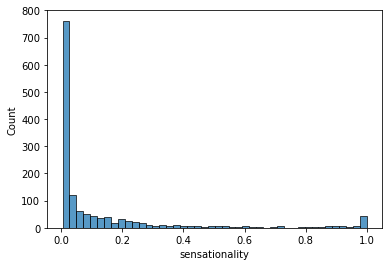

In [341]:
sns.histplot(pop_metrics['sensationality'])

In [ ]:
# y_col = 'sensationality'
# y = data_df.pop(y_col)